# Global Arakawa A-grid - Forward tracking

The use of PyLag with local/regional model outputs defined on an Arakawa A-grid was demonstrated in the [previous example](./arakawa_a_forward_tracking.ipynb). Here we demonstrate the use of PyLag with data defined on a global Arakawa A-grid. For the example, we use [E.U. Copernicus Marine Service Information](https://marine.copernicus.eu/), product [GLOBAL_REANALYSIS_PHY_001_031](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=GLOBAL_REANALYSIS_PHY_001_031). The product includes monthly output from an ensemble of model simulations run at 1/4 degree resolution. For the example, we have extracted surface fields for the FOAM ensemble member. Data have been extracted for the years 2016 - 2017. More information about the data can be found in the [product user guide](http://marine.copernicus.eu/documents/PUM/CMEMS-GLO-PUM-001-031.pdf) and [quality information](http://marine.copernicus.eu/documents/QUID/CMEMS-GLO-QUID-001_031.pdf) documents. The experiment involves releasing particles into surface waters off the coast of Florida.

As is the case in the other examples, the input files needed to run the example can be [downloaded here](https://drive.google.com/open?id=15UX7Y9JnuLpnPAz700mzmzd917nTClxR).  If you would like to run the code in this notebook interactively, download the data into a directory of your chooising. By default, the notebook will look for these files in the directory `${HOME}/data/pylag_doc`. To change this, simply update the *data_dir* path below.

In [1]:
import os
import warnings

# Root directory for PyLag example input files
data_dir='{}/data/pylag_doc'.format(os.environ['HOME'])

warnings.filterwarnings('ignore')

# Keep a copy of the cwd
cwd = os.getcwd()

# Create run directory
simulation_dir = '{}/simulations/global_arakawa_a_forward'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# Create input sub-directory
input_dir = '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

## Setting particle initial positions

The creation of the initial positions file follows the same process described in the [previous example](./arakawa_a_forward_tracking.ipynb), only here particles are started from a location off the coast of Florida.

In [2]:
import matplotlib

from pylag.processing.coordinate import utm_from_lonlat, lonlat_from_utm
from pylag.processing.release_zone import create_release_zone
from pylag.processing.input import create_initial_positions_file_single_group

# Ensure inline plotting
%matplotlib inline

# The group ID of this particle set
group_id = 1

# Lat and lon coordiantes for the centre of the release zone
lat = 28.5
lon = -78.7

# Convert to UTM coordinates
easting, northing, epsg_code = utm_from_lonlat([lon], [lat])
easting = easting[0]
northing = northing[0]

# Release zone radius (m)
radius = 10000.0

# Number of particles to be released.
n_particles_target = 1000

# Release depths
depth_below_surface = 0.0

# Create the release zone
surface_release_zone = create_release_zone(group_id = group_id,
                                           radius = radius,
                                           centre = [easting, northing],
                                           n_particles = n_particles_target,
                                           depth = depth_below_surface,
                                           random = True)

# Get the actual number of particles
n_particles = surface_release_zone.get_number_of_particles()

# Convert to lat/lon coordinates
lons, lats = lonlat_from_utm(surface_release_zone.get_eastings(),
                             surface_release_zone.get_northings(),
                             epsg_code)

# Get depths
depths = surface_release_zone.get_depths()

# Output filename
file_name = '{}/initial_positions.dat'.format(input_dir)

# Write data to file
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           lons,
                                           lats,
                                           depths)

## Creating an Arakawa A grid metrics file

As in previous examples, we first generate a grid metrics file which contains variables that describe the input grid. A grid metrics file has been pre-created and is shipped with the input data. However, for completeness, and to demonstrate several features distinct to running with global data, we recreate a new grid metrics file from the input data.

In [3]:
from pylag.grid_metrics import create_arakawa_a_grid_metrics_file

# An example Arakawa A output file
arakawa_a_file_name = '{}/grepv2_monthly_surface_2016_2017.nc'.format(data_dir)

# The name of the output file
grid_metrics_file_name = '{}/grid_metrics.nc'.format(input_dir)

# Generate the file
create_arakawa_a_grid_metrics_file(arakawa_a_file_name,
                                   lon_var_name='longitude',
                                   lat_var_name='latitude',
                                   reference_var_name='uo_foam',
                                   is_global=True,
                                   surface_only=True,
                                   prng_seed=100,
                                   grid_metrics_file_name=grid_metrics_file_name)

Reading the grid:
Reading variable `longitude` ... done
Reading variable `latitude` ... done
Trimming last latitude which sits over a pole (90.0 deg.)
Reading variable `uo_foam` ... done
Sorting axes for variable `uo_foam`... done

Creating the triangulation ... done

Identifying neighbour simplices:

Searching for adjoining neighbours with k = 4 ... found 58.781114749008886 %

Searching for adjoining neighbours with k = 16 ... found 94.60190890912767 %

Searching for adjoining neighbours with k = 64 ... found 98.76424379951756 %

Searching for adjoining neighbours with k = 256 ... found 99.92223227580122 %

Searching for adjoining neighbours with k = 1024 ... found 99.99841707193029 %

Searching for adjoining neighbours with k = 4096 ... found 99.99948937804203 %

Searching for adjoining neighbours with k = 16384 ... found 100.0 %

Generating the land sea mask at element nodes:

Sorting the adjacency array ... done

Calculating lons and lats at element centres ... done

Calculating el

Some of the distinguishing features are as follows. First, in this example, we specify that we will only be working with surface data. This means that variables describing the bathymetry are not computed and saved as they are not needed. Second, we must explicitly say that the dataset is global in extent. When the flag `is_global` is set to *True*, PyLag will use the python package [stripy](https://github.com/underworldcode/stripy) to generate an unstructured representation of the underlying geographic Arakawa A-grid. Being global, the grid contains no open boundaries (only land boundaries) and the longitude coordinate is wrapped.

With global grids, special care is needed around the poles. From the log, it can be seen PyLag has automatically detected the input grid has a row of points that lie over the pole. The row of data, which contains only masked values, is automatically trimmed by PyLag in order to avoid the inclusion of duplicate points and a flag recorded in the grid metrics file that states the same row should be trimmed from all input arrays. We also pass in a value for `prng_seed`, which is the seed to use with the pseudo random number generator. A random number generator is used to randomly shuffle the longitude and latitude arrays. This is a requirement of the PyLag dependency stripy, which requires that [consective points do not lie along a great circle](https://github.com/underworldcode/stripy/blob/master/stripy/spherical.py) when building an unstructured spherical grid. The last point to note is that we pass in the name of a "reference variable". Typically, CMEMS data do not contain a variable describing the land mask. In the absence of a variable for the land mask, PyLag infers it from a masked reference variable. The same is true for the bathymetry - if a variable for the bathymetry has not been included, depths are inferred from the mask of a named variable with a depth axis. However, here this isn't a concern as we are running a surface only simulation.

Below we visualise the grid near to the coast of Florida, which is the site of the release location. Sea points are show in blue and masked points in red. The unstructured grid is drawn, with the exception of masked elements that have been excluded. Also drawn is a snapshot of the velocity field (black arrows), and the starting location of a sample of 50 particles (green dots).

Sorting axes for variable `uo_foam`... done
Sorting axes for variable `vo_foam`... done


(<GeoAxesSubplot:xlabel='Longitude (E)', ylabel='Longitude (N)'>,
 <matplotlib.collections.PathCollection at 0x7f8cafacc490>)

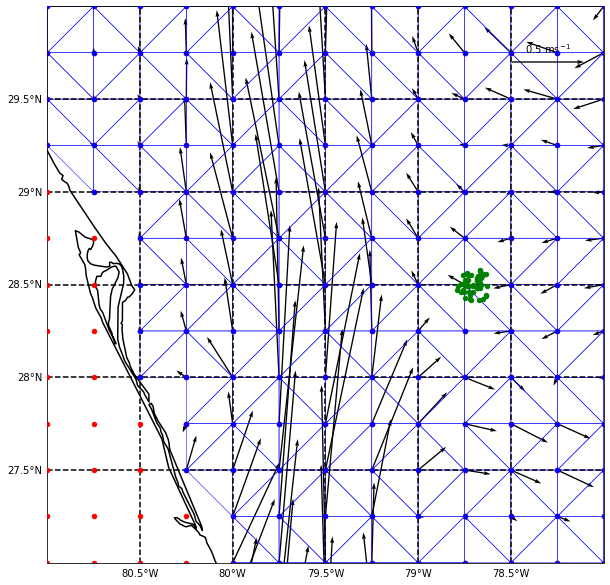

In [4]:
import numpy as np
from netCDF4 import Dataset, num2date
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pylag.grid_metrics import sort_axes
from pylag.processing.ncview import Viewer
from pylag.processing.plot import ArakawaAPlotter
from pylag.processing.plot import create_figure, ArakawaAPlotter

# Var names
u_var_name = 'uo_foam'
v_var_name = 'vo_foam'

# Grid metrics viewer
viewer_gm = Viewer(grid_metrics_file_name)
x = viewer_gm('longitude')[:]
y = viewer_gm('latitude')[:]
mask = viewer_gm('mask')[:]
ocean_points = np.asarray(mask!=1).nonzero()[0]

# Data viewer
viewer = Viewer(arakawa_a_file_name)

# Helper function which sorts variable axes for use with PyLag
u = sort_axes(viewer(u_var_name))[0, 0, :, :]
v = sort_axes(viewer(v_var_name))[0, 0, :, :]

# The figure
fig, ax = create_figure(figure_size=(26, 26), projection=ccrs.PlateCarree())

# Create plotter
plotter = ArakawaAPlotter(grid_metrics_file_name, line_width=1.5)

# Plot the velocity field
extents = [-81, -78, 27, 30]
plotter.plot_quiver(ax, u, v,
                    preprocess_arrays=True, extents=extents,
                    draw_coastlines=True)

# Draw the grid
_ = plotter.draw_grid(ax, linewidth=0.5, edgecolor='b')

# Add on scatter plot of grid nodes (blue for ocean points, red for masked points)
_ = plotter.scatter(ax, x, y, c='r', s=20)
_ = plotter.scatter(ax, x[ocean_points], y[ocean_points], c='b', s=20)

# Add on scatter of particle starting positions
_ = plotter.scatter(ax, lons[:50], lats[:50], c='g', s=20)

It can be seen valid elements contain no masked points (represented by red dots). In PyLag, it is possible to construct grids in which boundary elements have one or two nodes masked using the keyword argument `masked_vertices_per_element` with the function`create_arakawa_a_grid_metrics_file`. By default, this argument takes a value of zero, which is the case here. The inclusion of masked elements may make it possible for particles to pass through narrow channels that would otherwise be masked off. If masked nodes are included, PyLag adopts a nearest neighbour interpolation scheme in boundary elements. The second point to note is the direction of velocity vectors along the coast. The CMEMS products are typically interpolated onto a regular grid before being submitted to the catalogue. This can result in dynamics near to the coast being poorly represented, with velocity vectors often pointing directly onto land and thus out of the grid. This is a well known problem that arises when running particle tracking simulations using regridded products. The problem is common to regional or local products, like that used in the previous example, as well as global ones. Unless a procedure is used to reintroduce particles back into the domain, large numbers can become beached on land. In the simulation here, we use a reflecting boundary condition to push particles back into the domain should this occur.

## Creating the run configuration file

As before, a [run configuration](../documentation/getting_started.ipynb) file has been provided. There is nothing special about he run config when compared with that used in the previous example - all the information that is secific to global products is recorded in the grid metrics file. The simulation uses a time step (3600 s), and is run forward for 360 days. It is an advection only simulation, which uses a fourth order Runga Kutta scheme to compute changes in particle positions over time.

Here we set `data_dir` and the path to the grid metrics file, and save the new config file in the simulation directory.

In [5]:
import configparser

config_file_name = './configs/global_arakawa_a_forward_template.cfg'

cf = configparser.ConfigParser()
cf.read(config_file_name)

cf.set('OCEAN_CIRCULATION_MODEL', 'data_dir', data_dir)
cf.set('OCEAN_CIRCULATION_MODEL', 'grid_metrics_file', grid_metrics_file_name)

# Save a copy in the simulation directory
with open("{}/pylag.cfg".format(simulation_dir), 'w') as config:
    cf.write(config)

## Running the model

With the run configuration file saved, we can now run the example.

In [6]:
# Change to the run directory
os.chdir('{}'.format(simulation_dir))

# Run the model
!{"python -m pylag.main -c pylag.cfg"}

# Return to the cwd
os.chdir(cwd)

## Visualising the result

With the model having run, the final step is to visulise the result. Here, we produce a simple plot of particles positions after 180 (top) and 360 (bottom) days.

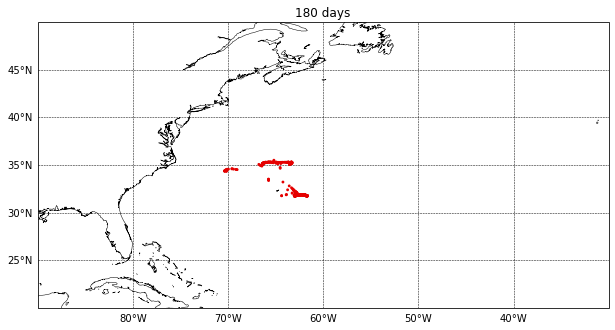

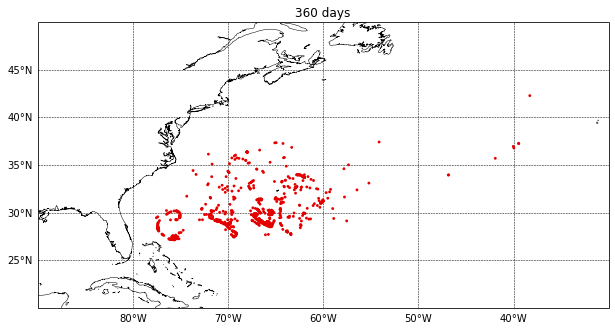

In [7]:
from datetime import timedelta

from pylag.processing.ncview import Viewer

# Dataset holding particle positions
file_name = '{}/output/pylag_1.nc'.format(simulation_dir)
viewer = Viewer(file_name, time_rounding=900)

# Font size
font_size = 10

# Plot extents
extents = np.array([-90, -30, 20, 50], dtype=float)

# Projection
#projection = ccrs.NearsidePerspective(central_longitude=-60.0, central_latitude=35.0, satellite_height=35785800)
projection = ccrs.PlateCarree()

# Plot positions after 180 and 360 days
for tof in [180, 360]:

    # Create figure
    fig, ax1 = create_figure(figure_size=(26., 26.), projection=projection, font_size=font_size, bg_color='white')

    # Create plotter 
    plotter = ArakawaAPlotter(grid_metrics_file_name,
                              font_size=font_size,
                              line_width=0.5)

    # Time of flight
    time_of_flight = timedelta(days=tof)
    date = viewer.date[0] + time_of_flight
    time_index = viewer.date.tolist().index(date)


    # Plot particle final positions
    ax1, scatter = plotter.scatter(ax1, viewer('longitude')[time_index, :].squeeze(),
                         viewer('latitude')[time_index, :].squeeze(), configure=True,
                         s=8, color='#e50000', edgecolors='none', tick_inc=True,
                         draw_coastlines=True,
                         extents=extents)
    ax1.set_title('{} days'.format(tof))

The particles initially follow the Florida current north, before moving into the Gulf Stream near to Cape Hatteras and dispersing within the subtropical gyre of the North Atlantic ocean.

## Acknowledgments

The example uses E.U. Copernicus Marine Service Information (CMEMS), product [GLOBAL_REANALYSIS_PHY_001_031](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=GLOBAL_REANALYSIS_PHY_001_031).